In [1]:
import traceback
import numpy as np
from scipy.interpolate import UnivariateSpline
from scipy.ndimage import binary_dilation
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# AIM OF THIS NOTE BOOK

## download dataset
# https://cs.stanford.edu/~acoates/stl10/
# wget https://raw.githubusercontent.com/mttk/STL10/master/stl10_input.py
# python stl10_input.py

## add MULTIPLE lines to images.

## use above format dataset

## train yolo with images with line

In [3]:
from extract_centerline import extract_centerline
from scipy.interpolate import UnivariateSpline
def smooth_line(x,y,num=None,**kwargs):
    if num is None:
        num = len(x)
    w = np.arange(0,len(x),1)
    sx = UnivariateSpline(w,x,**kwargs)
    sy = UnivariateSpline(w,y,**kwargs)
    wnew = np.linspace(0,len(x),num)
    return sx(wnew),sy(wnew)

In [4]:
def make_line(nx=256,ny=256):
    sz = (nx,ny)
    canvas = np.zeros(sz)

    peak_num = np.random.randint(0,10,1)[0]
    for n in range(peak_num):
        x = np.random.choice(np.linspace(0, nx-1, nx),1).astype(np.int)[0]
        y = np.random.choice(np.linspace(0, ny-1, ny),1).astype(np.int)[0]
        canvas[x,y]=1

    distance = ndi.distance_transform_edt(np.logical_not(canvas))
    terrain = ndi.morphology.distance_transform_edt(distance)
    terrain = -1*terrain + -1*np.min(-1*terrain)


    prct = np.random.randint(25,75,1)[0]
    th = np.percentile(terrain.ravel(),prct)
    mask = terrain<th
    mask = np.expand_dims(mask,axis=-1)
    minlen = 50
    count0=0
    while True:
        pt = []
        for n in range(2):
            count1=0
            breakok = False
            while True:
                x = np.random.choice(np.linspace(0, nx-1, nx),1).astype(np.int)[0]
                y = np.random.choice(np.linspace(0, ny-1, ny),1).astype(np.int)[0]
                z = 0
                if len(pt)==0 and mask[x,y,z] == 1:
                    breakok = True
                if len(pt)==1 and mask[x,y,z] == 1 and \
                    np.abs(x-pt[0][0]) > minlen and np.abs(y-pt[0][1]) > minlen:
                    breakok = True
                if breakok:
                    break
                count1+=1
                if count1>100:
                    raise LookupError('ok1')
            pt.append((x,y,z))
        start_point = pt[0]
        end_point = pt[1]
        line = extract_centerline(mask,start_point,end_point)
        linexorg,lineyorg,linez=line
        smothing_factor=np.random.rand()*1000
        try:
            linex,liney = smooth_line(linexorg,lineyorg,num=100*len(linexorg),s=smothing_factor)
        except:
            pass
        if len(linexorg) > 5:
            break
            
        count0+=1
        if count0>200:
            raise LookupError('ok0')
            
    mask = mask.squeeze()
    return mask, terrain, linexorg,lineyorg, linex, liney


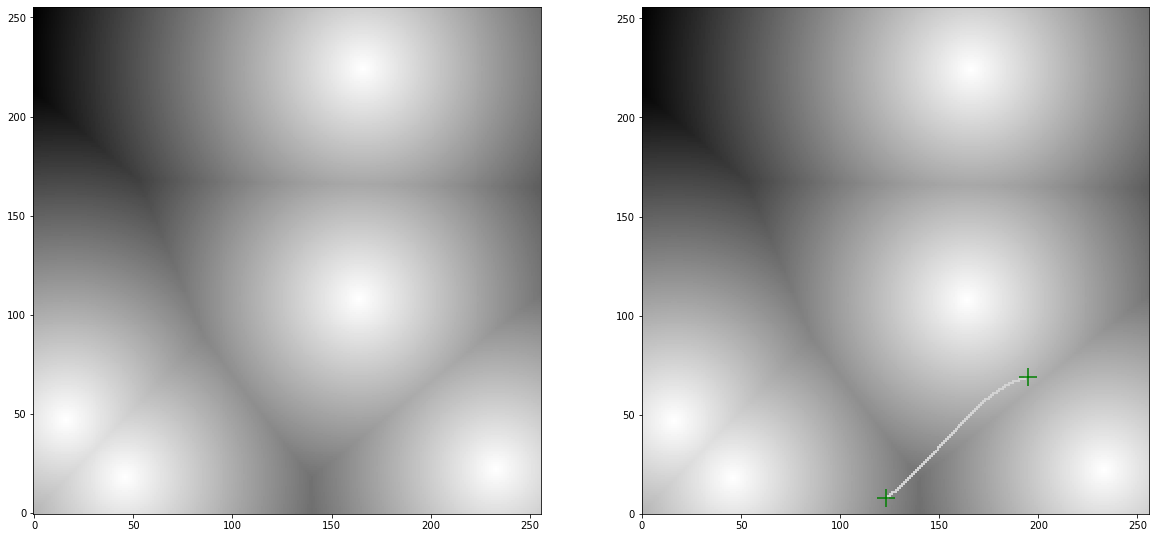

In [33]:
# create dataset with multiple lines

def make_one_sample(isplot=False,fignum=0,nx=256,ny=256,baseimage=None):
    if baseimage is None:
        maskorg, orgimage, linexorg,lineyorg, linex, liney = make_line(nx=nx,ny=ny)
        myimage = np.copy(orgimage)
    else:
        orgimage = np.copy(baseimage)
        myimage = np.copy(baseimage)
        
    mymax = np.max(myimage)
    linmax = np.random.randint(0,10,1)[0]
    container = []
    print()
    for x in range(linmax):
        prct = np.random.randint(70,90,1)[0]
        mymax = np.percentile(orgimage.ravel(),prct)
        _, _, linexorg,lineyorg, linex, liney = make_line()
        mask = np.zeros(myimage.shape)
        for x,y in zip(linex,liney):
            try:
                myimage[x.astype(int),y.astype(int)]=mymax
                mask[x.astype(int),y.astype(int)]=1
            except:
                pass
        endpoints = [[linex[0], liney[0]],[linex[-1], liney[-1]]]
        container.append({
            'mask':mask,
            'endpoints':endpoints,
        })
    if isplot:
        fig = plt.figure(fignum,figsize=(20,20))
        plt.subplot(121)
        plt.imshow(orgimage,cmap='gray',origin='lower')
        plt.subplot(122)
        for item in container:
            plt.scatter(item['endpoints'][0][1],item['endpoints'][0][0],300,'green',marker='+')
            plt.scatter(item['endpoints'][1][1],item['endpoints'][1][0],300,'green',marker='+',)
        plt.imshow(myimage,cmap='gray',origin='lower')
        plt.xlim(0,nx)
        plt.ylim(0,ny)
        
    return myimage, container

terrain, container = make_one_sample(isplot=True)

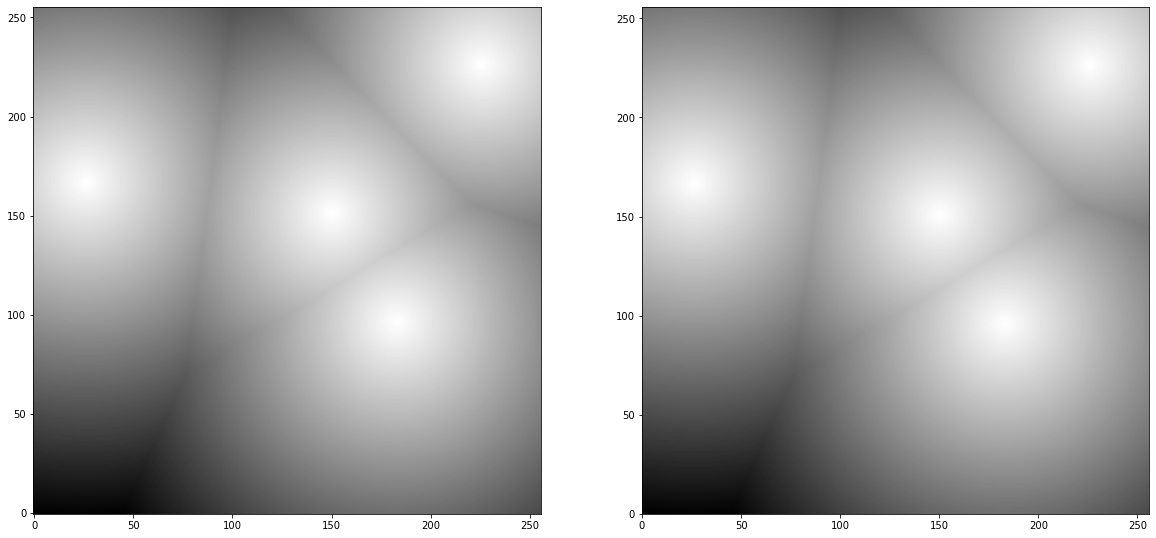

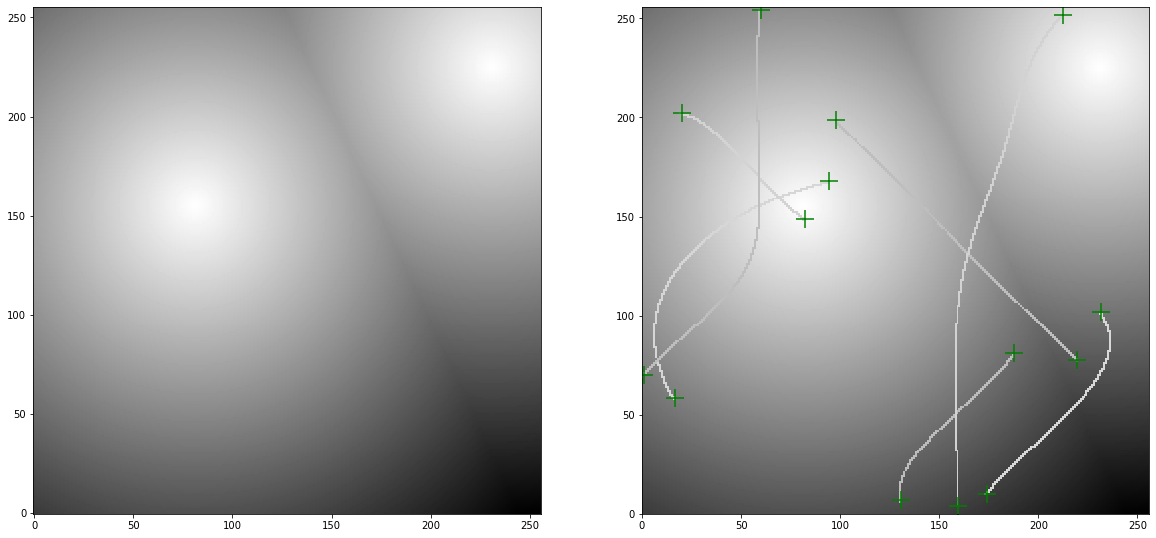

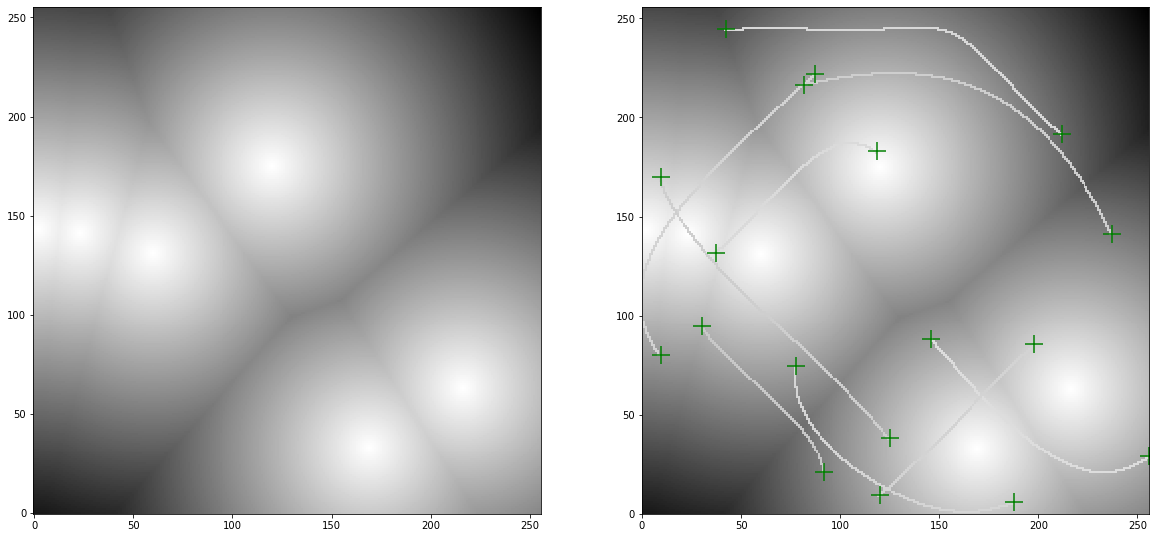

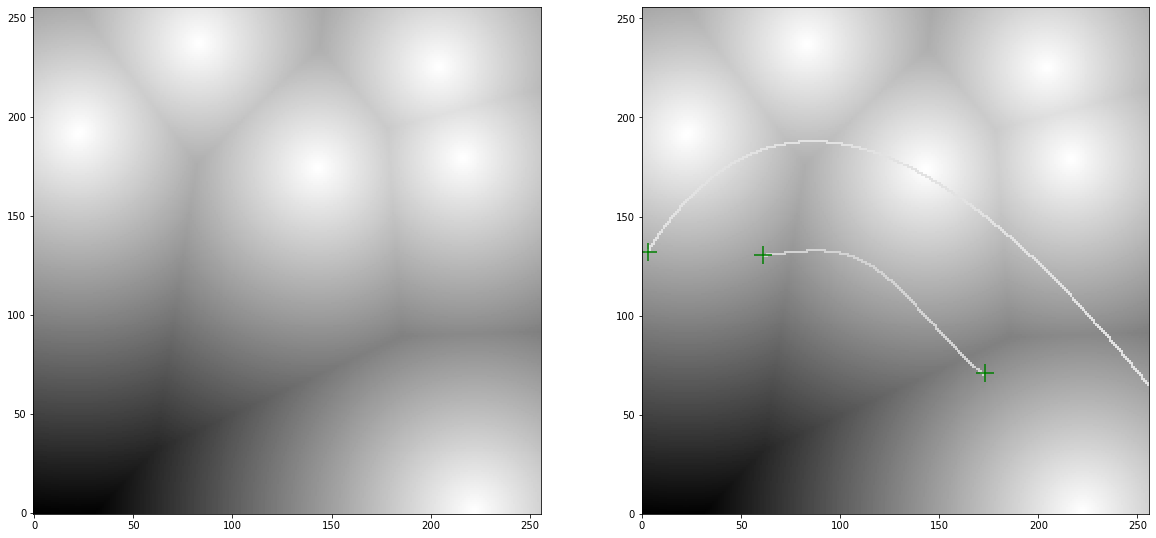

In [34]:
for n in range(5):
    try:
        terrain, container = make_one_sample(isplot=True,fignum=n)
    except:
        pass
        #traceback.print_exc()

In [35]:
import SimpleITK as sitk
from PIL import Image
from skimage.transform import rescale
import yaml

def imread(fpath):
    reader= sitk.ImageFileReader()
    reader.SetFileName(fpath)
    img = reader.Execute()
    arr = sitk.GetArrayFromImage(img)    
    spacing = img.GetSpacing()
    origin = img.GetOrigin()
    direction = img.GetDirection()    
    return arr,spacing,origin,direction

with open('/media/external/Downloads/data/luna16.yml','r') as f:
    luna16 = yaml.load(f.read())

def get_xray(isplot=False,fignum=n):
    
    filepath = np.random.choice(luna16)
    img,spacing,origin,direction = imread(filepath)
    xray = np.sum(img,axis=1)
    xray = (255.0 * (xray - xray.min())/(xray.max()-xray.min()))

    new_width = 256
    new_height = 256
    xray = rescale(xray,
                (spacing[2],spacing[0]),
                 anti_aliasing=True)
    xray = xray.astype(np.uint8)
    xray = Image.fromarray(xray,mode="L")
    xray = xray.resize((new_width, new_height), Image.ANTIALIAS)
    xray = np.array(xray)
    xray, container = make_one_sample(isplot=isplot,fignum=fignum,nx=256,ny=256,baseimage=xray)
    return xray, container

    #im = Image.fromarray(xray,mode="L")
    #im = im.resize((new_width, new_height), Image.ANTIALIAS)
    #im.save('testXray.png',"PNG")


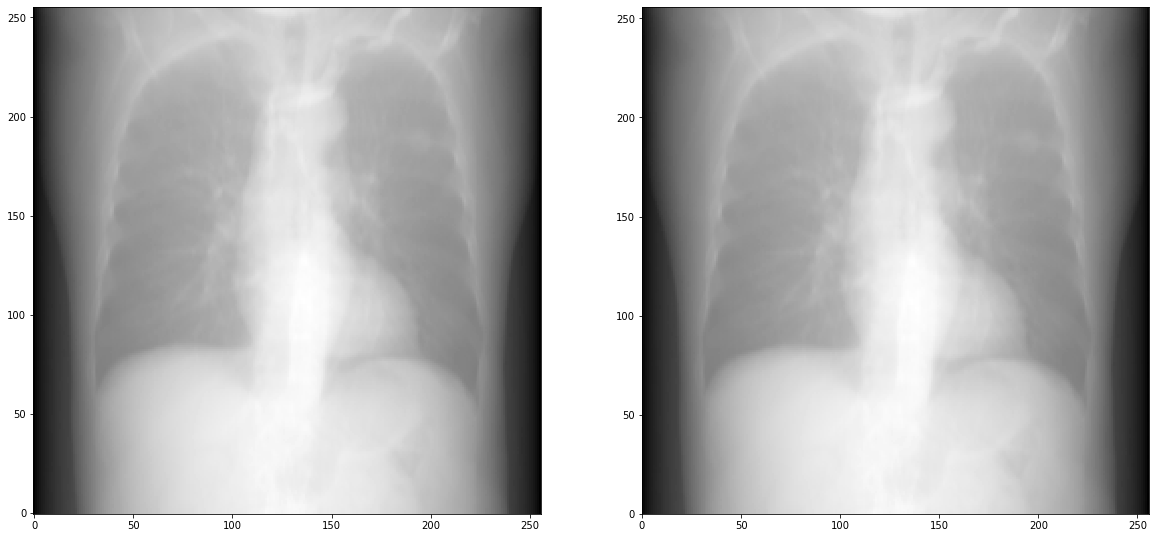

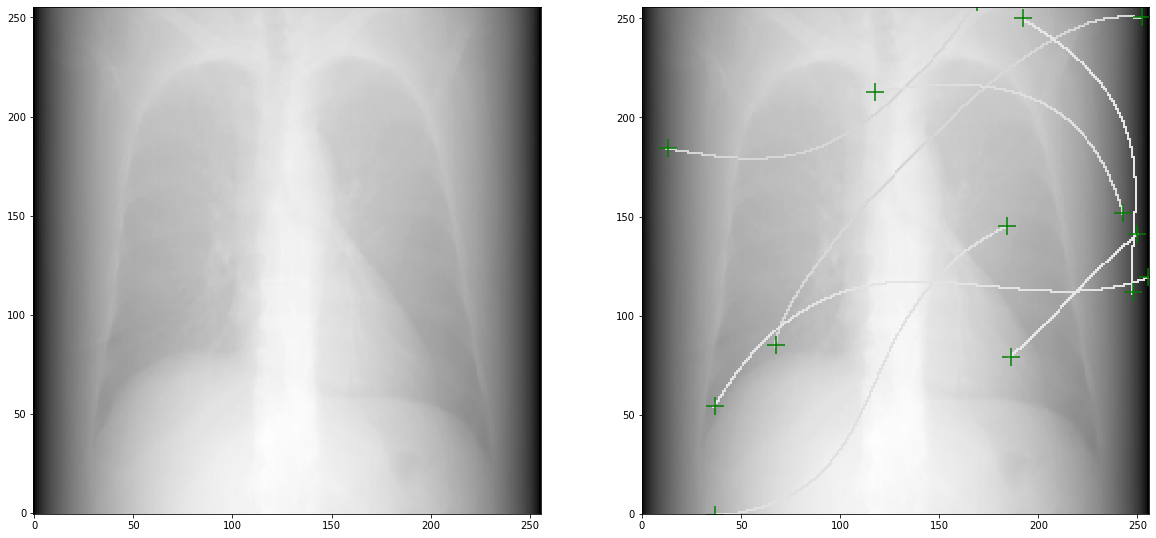

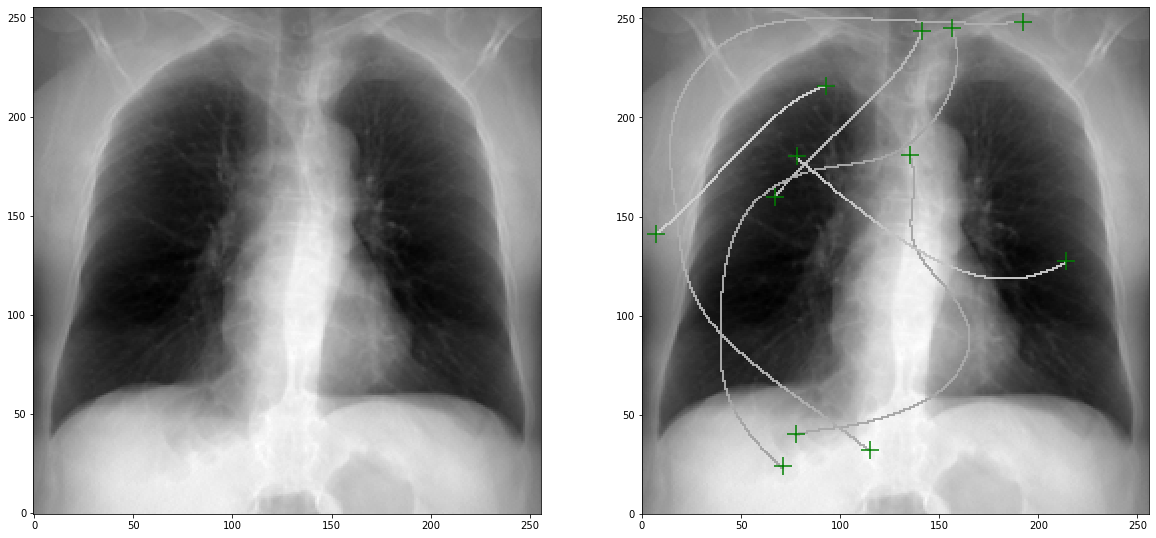

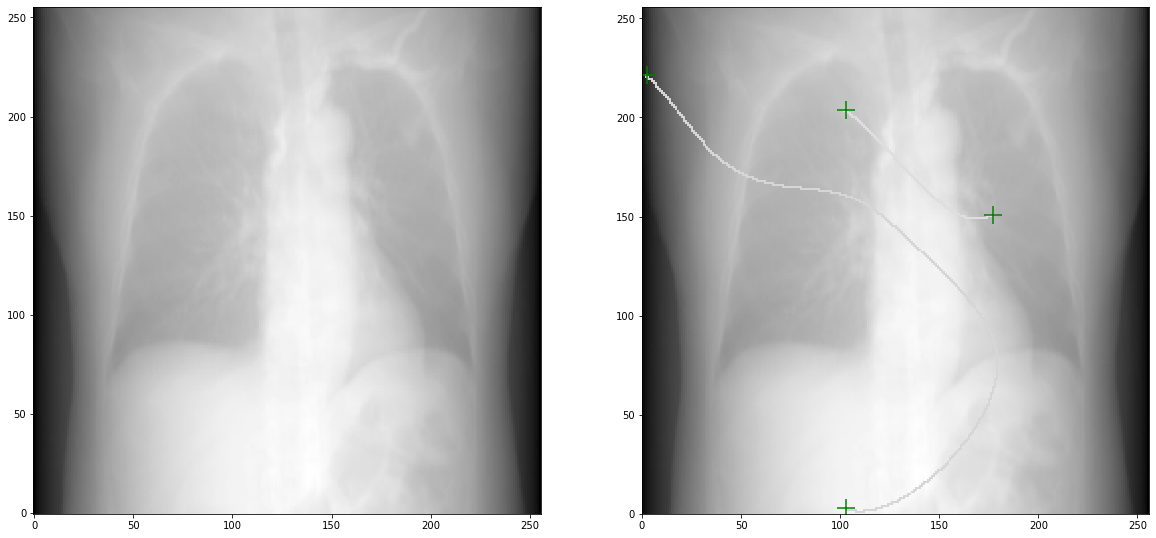

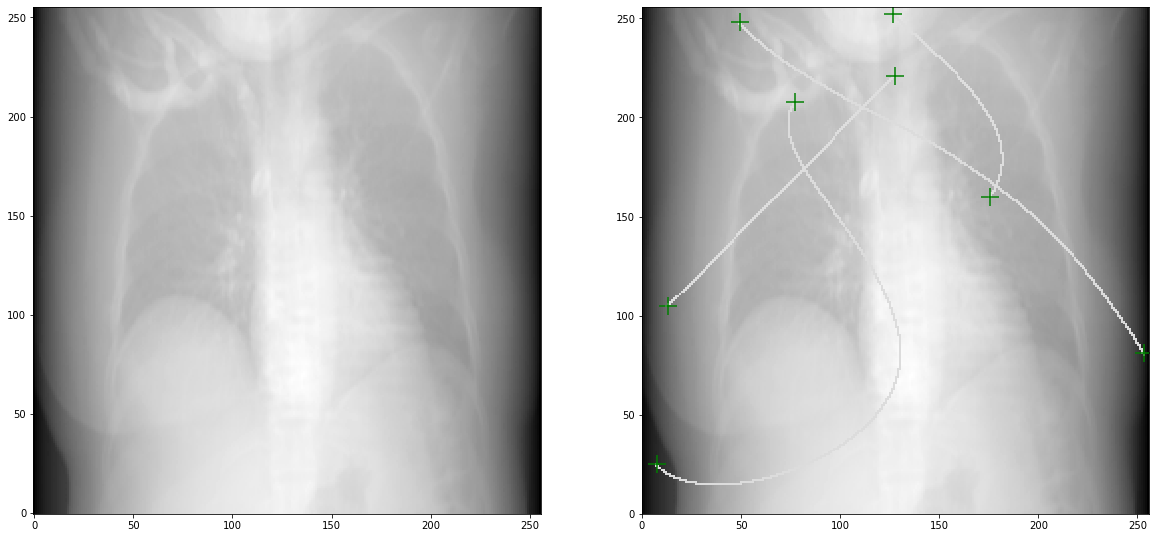

In [36]:
for n in range(5):
    try:
        xray, container = get_xray(isplot=True,fignum=n)
    except:
        pass
        traceback.print_exc()
